In [1]:
import os
os.environ["CONDA_PREFIX"] = "/opt/conda" if os.path.exists("/opt/conda") else '/usr/local'
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torcheval mlxtend torchsummary scikit-learn-intelex

Resolved 44 packages in 384ms
Downloaded 15 packages in 1.24s
Installed 15 packages in 75ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifac

# Imports


In [3]:
import random
import warnings
from pathlib import Path
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearnex import patch_sklearn
from skorch import NeuralNetClassifier
from torch import nn
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
from torchsummary import summary
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

if not os.path.exists("reports_Face"): os.mkdir("reports_Face")
patch_sklearn()
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data


## Face


In [4]:
def jpg_to_numpy(images):
    numpy_images = []
    for img_path in images:
        img = Image.open(img_path)
        numpy_img = np.array(img)
        numpy_images.append(numpy_img)
    return numpy_images

In [5]:
def load_data(data, samples=10000):
    images = []
    labels = []
    indices = np.random.choice(range(len(data)), size=samples, replace=False)
    for i in indices:
        images.append(data[i][0])  
        labels.append(data[i][1])
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    return images, labels

In [6]:
folders=['angry','disgust','disgust','fear','happy','neutral','sad','surprise']

TRAIN_DATA_PATH = "/kaggle/input/face-expression-recognition-dataset/images/train"
TEST_DATA_PATH = "/kaggle/input/face-expression-recognition-dataset/images/validation/"

TRANSFORM_IMG = transforms.Compose(
    [
        transforms.Resize(28),
        transforms.CenterCrop(28),
        transforms.ToTensor()
    ]
)

images_per_class_train = {}
images_per_class_test = {}

for folder in folders:
    class_train_path = os.path.join(TRAIN_DATA_PATH, folder)
    class_test_path = os.path.join(TEST_DATA_PATH, folder)

    train_image_paths = [os.path.join(class_train_path, filename) for filename in os.listdir(class_train_path)]
    test_image_paths = [os.path.join(class_test_path, filename) for filename in os.listdir(class_test_path)]

    images_per_class_train[folder] = train_image_paths
    images_per_class_test[folder] = test_image_paths

In [7]:
Face_train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
Face_test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

In [8]:
x_train, y_train = load_data(Face_train_data, len(Face_train_data))
x_test, y_test = load_data(Face_test_data, len(Face_test_data))

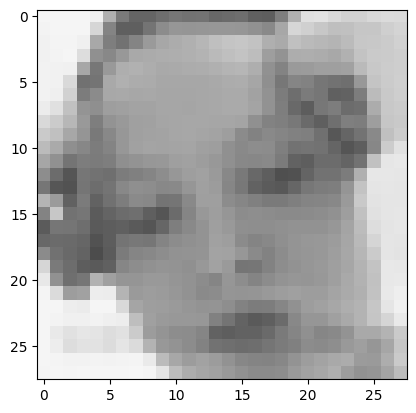

In [9]:
plt.imshow(torch.tensor(x_train[3]).permute(1, 2, 0).numpy())

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28821, 3, 28, 28), (28821,), (7066, 3, 28, 28), (7066,))

In [12]:
Face_class_names = Face_train_data.classes
Face_class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [13]:
num_classes = len(Face_class_names)
num_classes

7

In [14]:
class_to_idx_cif = Face_train_data.class_to_idx
class_to_idx_cif

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

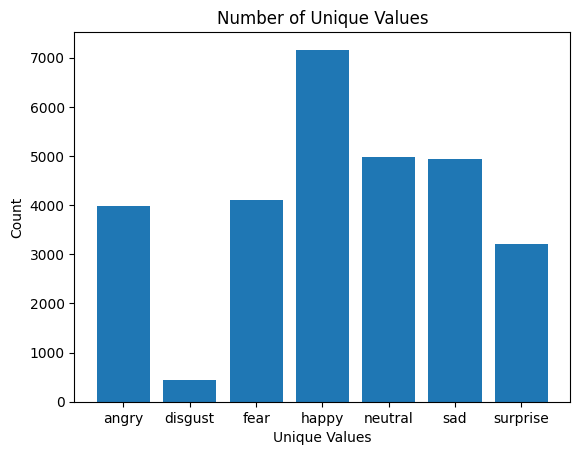

In [15]:
unique_values, counts = np.unique(y_train, return_counts=True)
plt.bar(Face_class_names, counts)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Number of Unique Values')
plt.savefig("reports_Face/Face_images_bar.png")
plt.show()

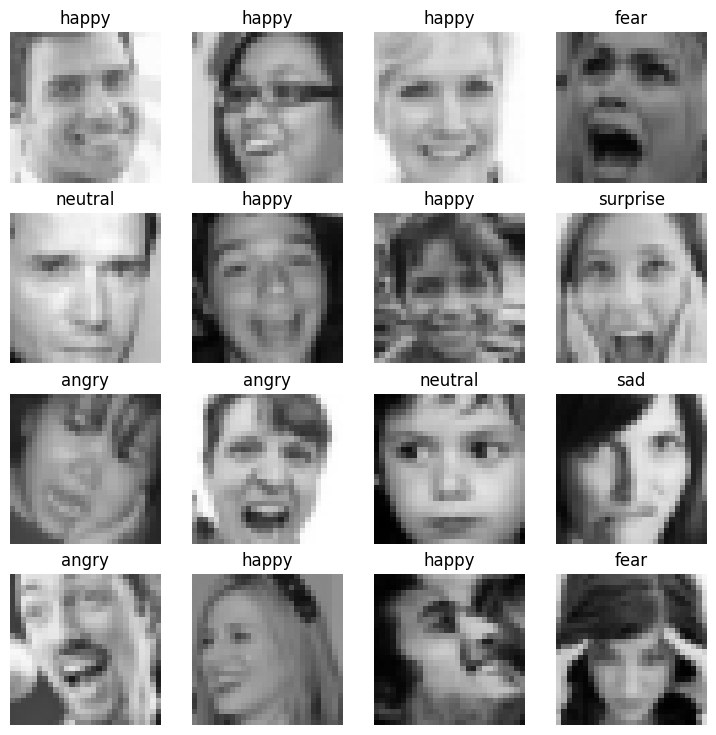

In [16]:
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = torch.randint(1, len(Face_train_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    image, label = Face_train_data[random_index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image, cmap="gray")
    plt.title(Face_class_names[label])
    plt.axis(False)

plt.savefig("reports_Face/Face_images_with_label.png")
plt.show()

## Unlabelling The Dataset


In [17]:
percentage_without_labels = 0.8

num_samples_without_labels = int(len(Face_train_data) * percentage_without_labels)
num_samples_with_labels = len(Face_train_data) - num_samples_without_labels

indices_without_labels = np.random.choice(
    range(len(Face_train_data)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(Face_train_data)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [18]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((5765, 3, 28, 28), (5765,), (23056, 3, 28, 28), (23056,))

In [19]:
len(Face_train_data)

28821

In [20]:
Face_train_data[1][1]

0

## Creating the DataLoaders


In [21]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [22]:
BATCH_SIZE_CIF = 32

In [23]:
Face_train_data_loader = numpy_to_dataloader(x_initial, y_initial, BATCH_SIZE_CIF)
Face_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [24]:
Face_train_data_loader, Face_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ef3d08543d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ef3d06dbd60>)

In [25]:
print(f"Length of Training Data loader: {len(Face_train_data_loader)}, Batches of {Face_train_data_loader.batch_size}")
print(f"Length of Testing Data loader: {len(Face_test_data_loader)}, Batches of {Face_test_data_loader.batch_size}")

Length of Training Data loader: 181, Batches of 32
Length of Testing Data loader: 221, Batches of 32


# Raw Model


## Importing and Using ResNet 50 Architecture


In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [27]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
next(model.parameters()).device

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


device(type='cpu')

In [28]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Printing the Architecture and Number of Training Parameters in each Layer


In [29]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [31]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")

In [32]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):
    training_loss = []
    training_acc = []
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        training_loss.append(loss)
        training_acc.append(
            multiclass_accuracy(y_pred.argmax(dim=1), y, num_classes=10)
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_loss = torch.tensor(training_loss).mean()
    training_acc = torch.tensor(training_acc).mean()
    print(f"Training -> Loss: {training_loss:.3f} | Accuracy: {training_acc:.3f}")
    return training_acc, training_loss

In [33]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    testing_acc = []
    testing_loss = []
    testing_f1 = []
    testing_precision = []
    testing_recall = []
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = model(x)
            testing_loss.append(loss_fn(y_test_pred, y))
            testing_acc.append(
                multiclass_accuracy(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            testing_f1.append(
                multiclass_f1_score(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            testing_precision.append(
                multiclass_precision(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            testing_recall.append(
                multiclass_recall(y_test_pred.argmax(dim=1), y, num_classes=10)
            )

        testing_loss = torch.tensor(testing_loss).mean()
        testing_acc = torch.tensor(testing_acc).mean()
        testing_f1 = torch.tensor(testing_f1).mean()
        testing_precision = torch.tensor(testing_precision).mean()
        testing_recall = torch.tensor(testing_recall).mean()

    print(
        f"Testing -> Loss: {testing_loss:.3f} | Accuracy: {testing_acc:.3f} | F1 Score: {testing_f1:.3f} | Precision: {testing_precision:.3f} | Recall: {testing_recall:.3f}"
    )
    return testing_acc, testing_loss, testing_f1, testing_precision, testing_recall

## Training


In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start = timer()
epochs = 2
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []

for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    F1 = 0
    PRECISION = 0
    RECALL = 0
    ACC_TRAIN, LOSS_TRAIN = train_step(
        model, Face_train_data_loader, loss_fn, optimizer, device
    )
    ACC_TEST, LOSS_TEST, F1, PRECISION, RECALL = test_step(
        model, Face_test_data_loader, loss_fn, device
    )

    acc_TRAIN.append(ACC_TRAIN.detach().cpu().numpy())
    acc_TEST.append(ACC_TEST.detach().cpu().numpy())
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(PRECISION.detach().cpu().numpy())
    recall_result.append(RECALL.detach().cpu().numpy())
    f1_result.append(F1.detach().cpu().numpy())

print("\nTraining is finished!\n")
train_end = timer()
display_train_time(train_start, train_end, device=next(model.parameters()).device)

  0%|          | 0/2 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training -> Loss: 2.689 | Accuracy: 0.227
Testing -> Loss: 1.868 | Accuracy: 0.256 | F1 Score: 0.256 | Precision: 0.256 | Recall: 0.256

epoch: 2
--------------------------------------
Training -> Loss: 1.930 | Accuracy: 0.233
Testing -> Loss: 8.017 | Accuracy: 0.258 | F1 Score: 0.258 | Precision: 0.258 | Recall: 0.258

Training is finished!

Train time on device cuda:0: 17.875 seconds


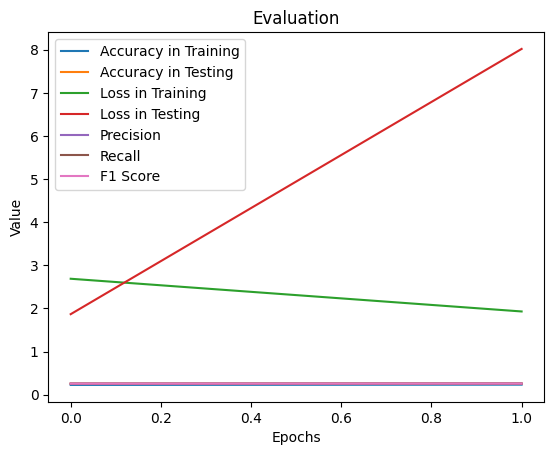

Accuracy in Training: 0.23308010399341583
Accuracy in Testing: 0.25796204805374146
Loss in Training: 1.9301923513412476
Loss in Testing: 8.017446517944336
Precision: 0.25796204805374146
Recall: 0.25796204805374146
F1 Score: 0.25796204805374146


In [35]:
fig, ax = plt.subplots()

plt.plot(acc_TRAIN, label="Accuracy in Training")
plt.plot(acc_TEST, label="Accuracy in Testing")
plt.plot(loss_TRAIN, label="Loss in Training")
plt.plot(loss_TEST, label="Loss in Testing")
plt.plot(precision_result, label="Precision")
plt.plot(recall_result, label="Recall")
plt.plot(f1_result, label="F1 Score")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Evaluation")

plt.legend()
plt.savefig("reports_Face/raw_model_evaluations_before_al.png")
plt.show()

print(f"Accuracy in Training: {acc_TRAIN[-1]}")
print(f"Accuracy in Testing: {acc_TEST[-1]}")
print(f"Loss in Training: {loss_TRAIN[-1]}")
print(f"Loss in Testing: {loss_TEST[-1]}")
print(f"Precision: {precision_result[-1]}")
print(f"Recall: {recall_result[-1]}")
print(f"F1 Score: {f1_result[-1]}")

In [36]:
torch.manual_seed(42)

In [37]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    model.eval()
    loss = 0
    acc = 0
    f1 = 0
    precision = 0
    recall = 0
    y_pred_list = []

    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += loss_fn(y_pred, y)
            y_pred_list.append(y_pred.argmax(dim=1).cpu().numpy())
            acc += multiclass_accuracy(torch.argmax(y_pred, dim=1), y, num_classes=10)
            f1 += multiclass_f1_score(y_pred.argmax(dim=1), y, num_classes=10)
            precision += multiclass_precision(y_pred.argmax(dim=1), y, num_classes=10)
            recall += multiclass_recall(y_pred.argmax(dim=1), y, num_classes=10)

        loss /= len(data_loader)
        acc /= len(data_loader)
        f1 /= len(data_loader)
        precision /= len(data_loader)
        recall /= len(data_loader)
        y_pred_list = np.concatenate(y_pred_list)

    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
    }, y_pred_list

In [38]:
model_results, y_pred = eval_model(model, Face_test_data_loader, loss_fn)

  0%|          | 0/221 [00:00<?, ?it/s]

In [39]:
model_results

{'Model Name': 'ResNet',
 'Model Loss': 8.017335891723633,
 'Model Accuracy': tensor(0.2579, device='cuda:0'),
 'F1 Score': tensor(0.2579, device='cuda:0'),
 'Precision': tensor(0.2579, device='cuda:0'),
 'Recall': tensor(0.2579, device='cuda:0')}

In [40]:
y_pred.shape

(7066,)

## Evaluating Model Visually


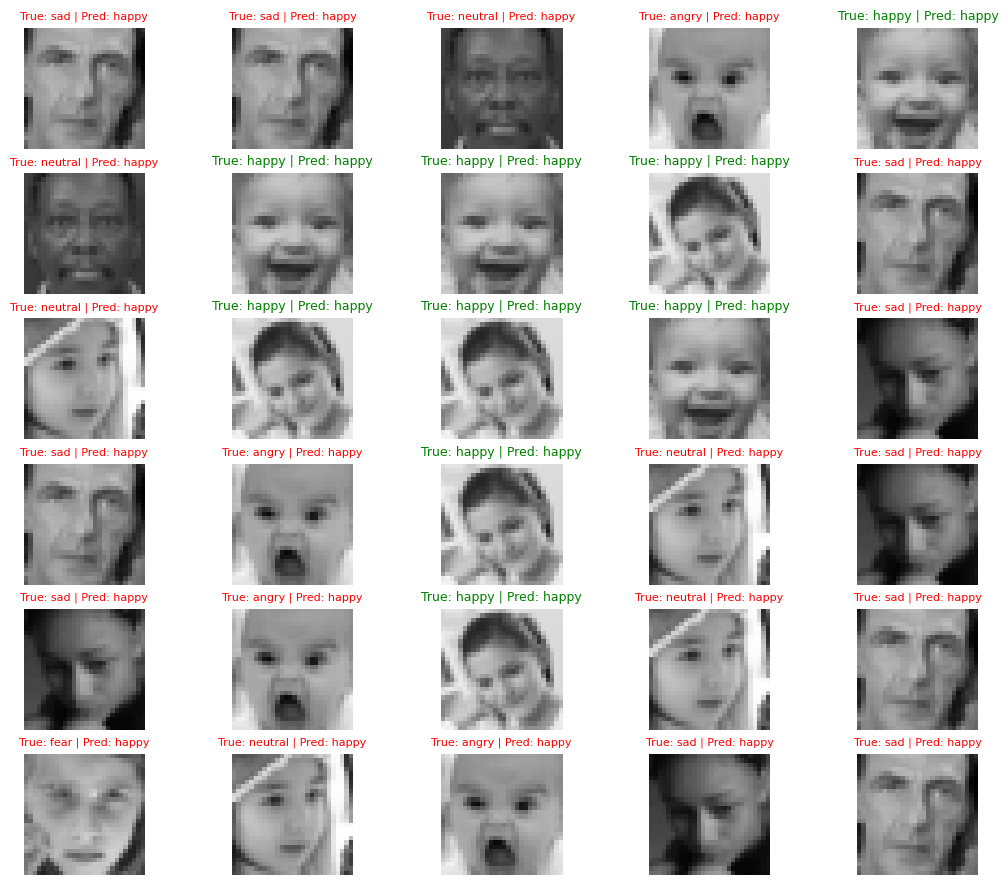

In [41]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(Face_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, cmap="gray")

        if pred_label == label:
            plt.title(
                f"True: {Face_class_names[label]} | Pred: {Face_class_names[pred_label]}",
                c="g",
                fontsize=9,
            )
        else:
            plt.title(
                f"True: {Face_class_names[label]} | Pred: {Face_class_names[pred_label]}",
                c="r",
                fontsize=8,
            )
        plt.axis(False)

plt.savefig("reports_Face/raw_model_predictions_before_al.png")

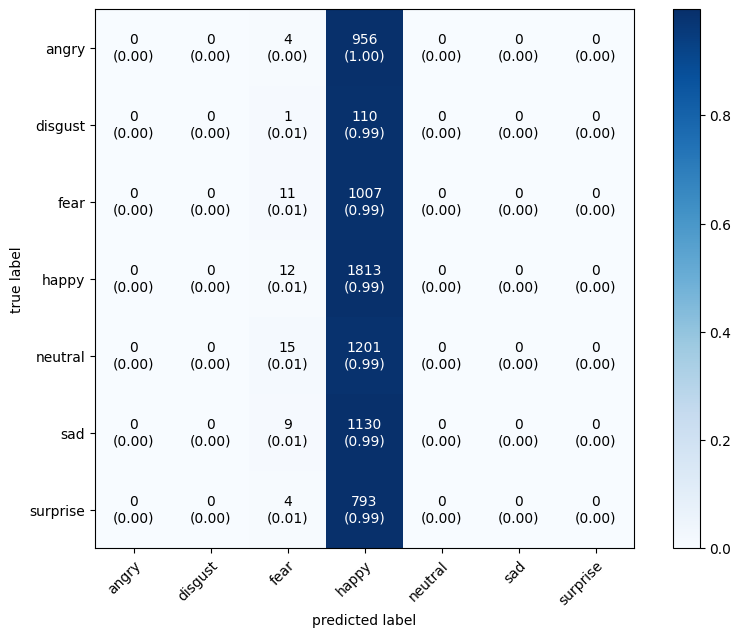

In [42]:
confusion_matrix = multiclass_confusion_matrix(
    torch.tensor(y_pred), torch.tensor(Face_test_data.targets), num_classes=7
)
plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=Face_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)

plt.savefig("reports_Face/raw_model_confusion_matrix_before_al.png")

## Saving the Model


In [43]:
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


## Load the Model


In [44]:
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, num_classes)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# Active Learning


In [46]:
cycles = 100

In [47]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=0,
    device=device,
)

In [48]:
trained_model.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

In [49]:
loss_fn = nn.MSELoss()

In [50]:
def active_learning(pool_x, pool_y, method, model_estimator, num_classes, class_names):
    learner = None
    acc_train = []
    acc_test = []
    precision_result = []
    recall_result = []
    f1_result = []
    loss = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=uncertainty_sampling)
    elif method == "margin_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=margin_sampling)
    elif method == "entropy_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=entropy_sampling)
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(estimator=model_estimator, query_strategy=random_sampling)
    elif method == "query_by_committee":
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):
            Learner = ActiveLearner(estimator=model_estimator)
            learner_list.append(Learner)
        learner = Committee(learner_list=learner_list, query_strategy=vote_entropy_sampling)
    else:
        print("Invalid Input")
        
    print(f"Starting Active Learning with {method.replace('_', ' ')} method")

    for cycle in range(cycles):
        print(f"Cycle: {cycle + 1}")
        query_idx, _ = learner.query(pool_x, n_instances=100)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)

        model_accuracy = learner.score(x_train, y_train)
        acc_train.append(model_accuracy)
        y_pred = learner.predict(x_test)

        acc_test.append(
            multiclass_accuracy(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        recall_result.append(
            multiclass_recall(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        f1_result.append(
            multiclass_f1_score(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        loss.append(
            loss_fn(
                torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            )
        )

        print(f"\tTraining Accuracy: {acc_train[-1]:.3f}")
        print(f"\tTesting Accuracy: {acc_test[-1]:.3f}")
        print(f"\tPrecision: {precision_result[-1]:.3f}")
        print(f"\tRecall: {recall_result[-1]:.3f}")
        print(f"\tF1 Score: {f1_result[-1]:.3f}")
        print(f"\tLoss: {loss[-1]:.3f}")
        
        try:
            slope = (loss[-1] - loss[-10]) / 9
            print("\tSlop after 10 Epochs", slope)
            if slope >= 0.01:
                break
        except Exception:
            continue

    print(f"Active Learning with {method} method is finished")
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
    )
    plot_confusion_matrix(
        conf_mat=confusion_matrix.numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )

    plt.savefig(f"reports_Face/{method}_confusion_matrix_after_al.png")
    return {
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": precision_result,
        "Recall": recall_result,
        "F1 Score": f1_result,
        "Loss": loss
    }

## Random Sampling


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


Starting Active Learning with random sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.242
	Testing Accuracy: 0.248
	Precision: 0.248
	Recall: 0.248
	F1 Score: 0.248
	Loss: 3.489
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.218
	Testing Accuracy: 0.225
	Precision: 0.225
	Recall: 0.225
	F1 Score: 0.225
	Loss: 4.044
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.210
	Testing Accuracy: 0.216
	Precision: 0.216
	Recall: 0.216
	F1 Score: 0.216
	Loss: 4.616
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.230
	Testing Accuracy: 0.236
	Precision: 0.236
	Recall: 0.236
	F1 Score: 0.236
	Loss: 3.511
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.248
	Testing Accuracy: 0.259
	Precision: 0.259
	Recall: 0.259
	F1 Score: 0.259
	Loss: 3.495
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.245
	Testing Accuracy: 0.244
	Precision: 0.244
	Recall: 0.244
	F1 Score: 0.244
	Loss: 4.840
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.255
	Testing Accuracy: 0.251
	Precision: 0.251
	Recall: 0.251
	F1 Score: 0.251
	Loss: 4.602
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.256
	Testing Accuracy: 0.240
	Precision: 0.240
	Recall: 0.240
	F1 Score: 0.240
	Loss: 7.010
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.281
	Testing Accuracy: 0.273
	Precision: 0.273
	Recall: 0.273
	F1 Score: 0.273
	Loss: 5.004
Cycle: 10
	Training Accuracy: 0.280
	Testing Accuracy: 0.262
	Precision: 0.262
	Recall: 0.262
	F1 Score: 0.262
	Loss: 5.675
	Slop after 10 Epochs tensor(0.2428)
Active Learning with random_sampling method is finished


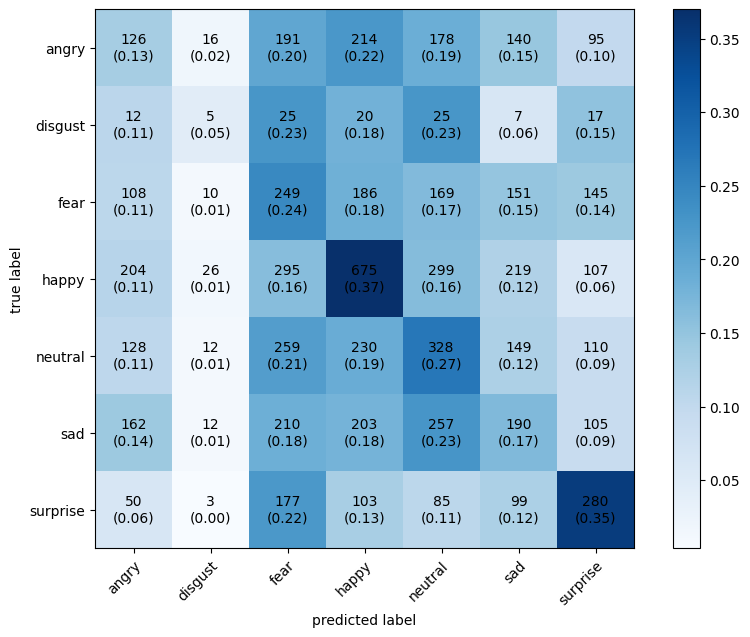

In [51]:
results_random_sampling = active_learning(
    x_pool, y_pool, "random_sampling", trained_model, 7, Face_class_names
)

## Uncertainty Sampling


Starting Active Learning with uncertainty sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.235
	Testing Accuracy: 0.238
	Precision: 0.238
	Recall: 0.238
	F1 Score: 0.238
	Loss: 6.358
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.261
	Testing Accuracy: 0.251
	Precision: 0.251
	Recall: 0.251
	F1 Score: 0.251
	Loss: 5.843
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.258
	Testing Accuracy: 0.252
	Precision: 0.252
	Recall: 0.252
	F1 Score: 0.252
	Loss: 5.776
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.258
	Testing Accuracy: 0.252
	Precision: 0.252
	Recall: 0.252
	F1 Score: 0.252
	Loss: 5.757
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.273
	Testing Accuracy: 0.268
	Precision: 0.268
	Recall: 0.268
	F1 Score: 0.268
	Loss: 5.777
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.278
	Testing Accuracy: 0.272
	Precision: 0.272
	Recall: 0.272
	F1 Score: 0.272
	Loss: 5.822
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.281
	Testing Accuracy: 0.273
	Precision: 0.273
	Recall: 0.273
	F1 Score: 0.273
	Loss: 5.726
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.299
	Testing Accuracy: 0.290
	Precision: 0.290
	Recall: 0.290
	F1 Score: 0.290
	Loss: 5.714
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.291
	Testing Accuracy: 0.282
	Precision: 0.282
	Recall: 0.282
	F1 Score: 0.282
	Loss: 5.969
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.304
	Testing Accuracy: 0.299
	Precision: 0.299
	Recall: 0.299
	F1 Score: 0.299
	Loss: 5.369
	Slop after 10 Epochs tensor(-0.1099)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.312
	Testing Accuracy: 0.299
	Precision: 0.299
	Recall: 0.299
	F1 Score: 0.299
	Loss: 5.465
	Slop after 10 Epochs tensor(-0.0420)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.316
	Testing Accuracy: 0.297
	Precision: 0.297
	Recall: 0.297
	F1 Score: 0.297
	Loss: 5.233
	Slop after 10 Epochs tensor(-0.0603)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.323
	Testing Accuracy: 0.312
	Precision: 0.312
	Recall: 0.312
	F1 Score: 0.312
	Loss: 5.359
	Slop after 10 Epochs tensor(-0.0442)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.321
	Testing Accuracy: 0.299
	Precision: 0.299
	Recall: 0.299
	F1 Score: 0.299
	Loss: 5.421
	Slop after 10 Epochs tensor(-0.0396)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.310
	Testing Accuracy: 0.292
	Precision: 0.292
	Recall: 0.292
	F1 Score: 0.292
	Loss: 5.602
	Slop after 10 Epochs tensor(-0.0245)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.331
	Testing Accuracy: 0.308
	Precision: 0.308
	Recall: 0.308
	F1 Score: 0.308
	Loss: 5.299
	Slop after 10 Epochs tensor(-0.0474)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.334
	Testing Accuracy: 0.303
	Precision: 0.303
	Recall: 0.303
	F1 Score: 0.303
	Loss: 5.632
	Slop after 10 Epochs tensor(-0.0090)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.337
	Testing Accuracy: 0.301
	Precision: 0.301
	Recall: 0.301
	F1 Score: 0.301
	Loss: 5.558
	Slop after 10 Epochs tensor(-0.0457)
Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.346
	Testing Accuracy: 0.309
	Precision: 0.309
	Recall: 0.309
	F1 Score: 0.309
	Loss: 5.404
	Slop after 10 Epochs tensor(0.0039)
Cycle: 20


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.324
	Testing Accuracy: 0.295
	Precision: 0.295
	Recall: 0.295
	F1 Score: 0.295
	Loss: 5.417
	Slop after 10 Epochs tensor(-0.0054)
Cycle: 21


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.340
	Testing Accuracy: 0.297
	Precision: 0.297
	Recall: 0.297
	F1 Score: 0.297
	Loss: 5.723
	Slop after 10 Epochs tensor(0.0545)
Active Learning with uncertainty_sampling method is finished


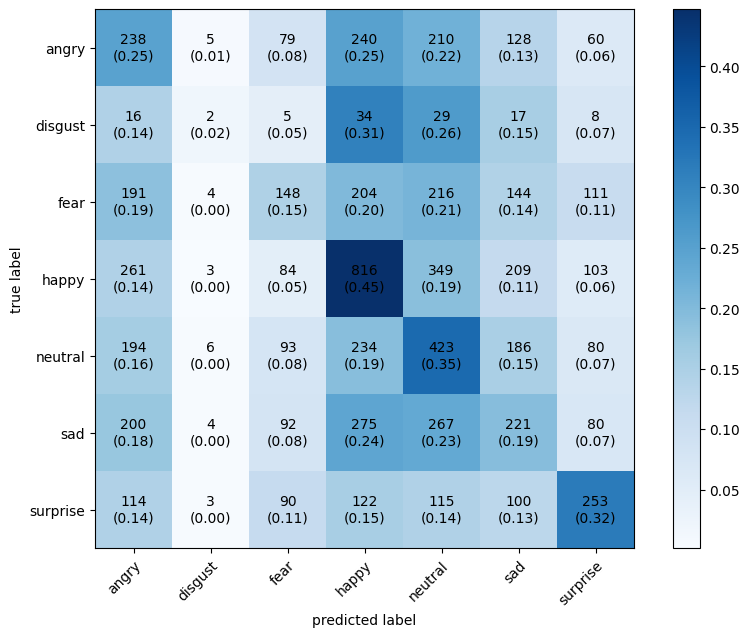

In [52]:
results_uncertainty_sampling = active_learning(
    x_pool, y_pool, "uncertainty_sampling", trained_model, num_classes, Face_class_names
)

## Margin Sampling


Starting Active Learning with margin sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.267
	Testing Accuracy: 0.255
	Precision: 0.255
	Recall: 0.255
	F1 Score: 0.255
	Loss: 8.101
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.275
	Testing Accuracy: 0.259
	Precision: 0.259
	Recall: 0.259
	F1 Score: 0.259
	Loss: 6.603
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.286
	Testing Accuracy: 0.271
	Precision: 0.271
	Recall: 0.271
	F1 Score: 0.271
	Loss: 5.156
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.278
	Testing Accuracy: 0.264
	Precision: 0.264
	Recall: 0.264
	F1 Score: 0.264
	Loss: 6.170
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.292
	Testing Accuracy: 0.273
	Precision: 0.273
	Recall: 0.273
	F1 Score: 0.273
	Loss: 6.215
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.296
	Testing Accuracy: 0.277
	Precision: 0.277
	Recall: 0.277
	F1 Score: 0.277
	Loss: 5.780
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.302
	Testing Accuracy: 0.280
	Precision: 0.280
	Recall: 0.280
	F1 Score: 0.280
	Loss: 5.762
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.314
	Testing Accuracy: 0.289
	Precision: 0.289
	Recall: 0.289
	F1 Score: 0.289
	Loss: 5.627
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.303
	Testing Accuracy: 0.278
	Precision: 0.278
	Recall: 0.278
	F1 Score: 0.278
	Loss: 5.790
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.319
	Testing Accuracy: 0.285
	Precision: 0.285
	Recall: 0.285
	F1 Score: 0.285
	Loss: 5.568
	Slop after 10 Epochs tensor(-0.2815)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.323
	Testing Accuracy: 0.293
	Precision: 0.293
	Recall: 0.293
	F1 Score: 0.293
	Loss: 5.596
	Slop after 10 Epochs tensor(-0.1119)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.320
	Testing Accuracy: 0.297
	Precision: 0.297
	Recall: 0.297
	F1 Score: 0.297
	Loss: 5.420
	Slop after 10 Epochs tensor(0.0294)
Active Learning with margin_sampling method is finished


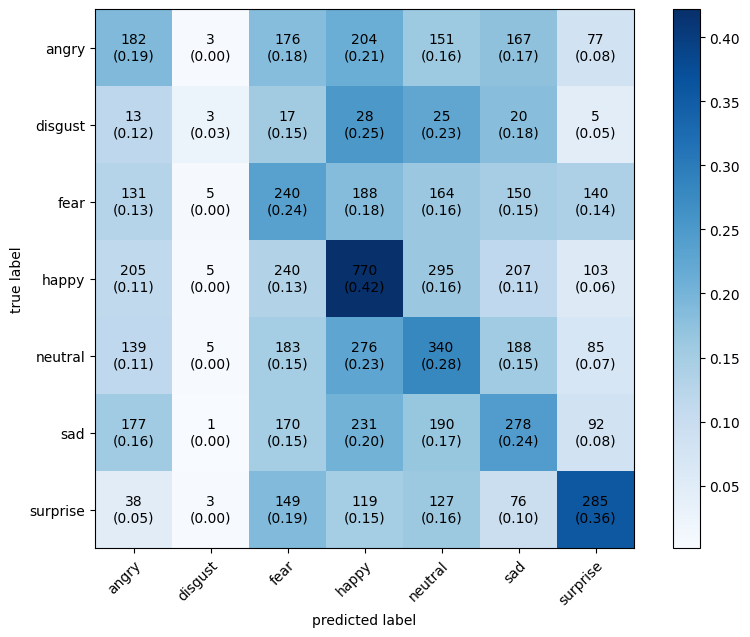

In [53]:
results_margin_sampling = active_learning(
    x_pool, y_pool, "margin_sampling", trained_model, 7, Face_class_names
)

## Entropy Sampling


Starting Active Learning with entropy sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.275
	Testing Accuracy: 0.260
	Precision: 0.260
	Recall: 0.260
	F1 Score: 0.260
	Loss: 5.896
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.293
	Testing Accuracy: 0.269
	Precision: 0.269
	Recall: 0.269
	F1 Score: 0.269
	Loss: 5.810
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.285
	Testing Accuracy: 0.261
	Precision: 0.261
	Recall: 0.261
	F1 Score: 0.261
	Loss: 5.966
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.282
	Testing Accuracy: 0.255
	Precision: 0.255
	Recall: 0.255
	F1 Score: 0.255
	Loss: 6.246
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.293
	Testing Accuracy: 0.269
	Precision: 0.269
	Recall: 0.269
	F1 Score: 0.269
	Loss: 5.482
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.299
	Testing Accuracy: 0.272
	Precision: 0.272
	Recall: 0.272
	F1 Score: 0.272
	Loss: 5.369
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.305
	Testing Accuracy: 0.279
	Precision: 0.279
	Recall: 0.279
	F1 Score: 0.279
	Loss: 5.435
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.311
	Testing Accuracy: 0.282
	Precision: 0.282
	Recall: 0.282
	F1 Score: 0.282
	Loss: 5.659
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.310
	Testing Accuracy: 0.286
	Precision: 0.286
	Recall: 0.286
	F1 Score: 0.286
	Loss: 5.235
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.316
	Testing Accuracy: 0.291
	Precision: 0.291
	Recall: 0.291
	F1 Score: 0.291
	Loss: 5.255
	Slop after 10 Epochs tensor(-0.0712)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.329
	Testing Accuracy: 0.293
	Precision: 0.293
	Recall: 0.293
	F1 Score: 0.293
	Loss: 5.328
	Slop after 10 Epochs tensor(-0.0535)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.318
	Testing Accuracy: 0.287
	Precision: 0.287
	Recall: 0.287
	F1 Score: 0.287
	Loss: 5.567
	Slop after 10 Epochs tensor(-0.0444)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.330
	Testing Accuracy: 0.309
	Precision: 0.309
	Recall: 0.309
	F1 Score: 0.309
	Loss: 5.464
	Slop after 10 Epochs tensor(-0.0869)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.336
	Testing Accuracy: 0.302
	Precision: 0.302
	Recall: 0.302
	F1 Score: 0.302
	Loss: 5.536
	Slop after 10 Epochs tensor(0.0059)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.341
	Testing Accuracy: 0.305
	Precision: 0.305
	Recall: 0.305
	F1 Score: 0.305
	Loss: 5.352
	Slop after 10 Epochs tensor(-0.0020)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.350
	Testing Accuracy: 0.307
	Precision: 0.307
	Recall: 0.307
	F1 Score: 0.307
	Loss: 5.456
	Slop after 10 Epochs tensor(0.0023)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.355
	Testing Accuracy: 0.308
	Precision: 0.308
	Recall: 0.308
	F1 Score: 0.308
	Loss: 5.332
	Slop after 10 Epochs tensor(-0.0364)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.353
	Testing Accuracy: 0.305
	Precision: 0.305
	Recall: 0.305
	F1 Score: 0.305
	Loss: 5.383
	Slop after 10 Epochs tensor(0.0164)
Active Learning with entropy_sampling method is finished


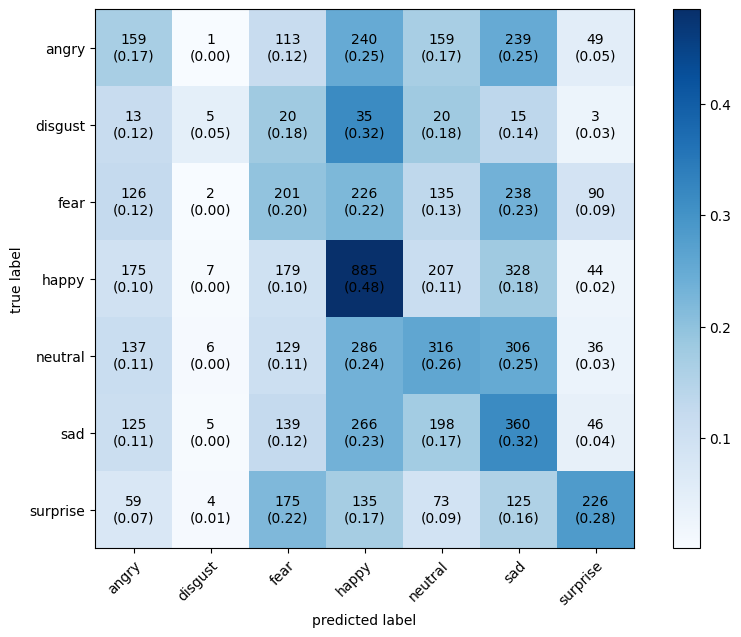

In [54]:
results_entropy_sampling = active_learning(
    x_pool, y_pool, "entropy_sampling", trained_model, 7, Face_class_names
)

## Query by Committee


Starting Active Learning with query by committee method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.297
	Testing Accuracy: 0.276
	Precision: 0.276
	Recall: 0.276
	F1 Score: 0.276
	Loss: 5.496
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.278
	Testing Accuracy: 0.264
	Precision: 0.264
	Recall: 0.264
	F1 Score: 0.264
	Loss: 5.906
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.276
	Testing Accuracy: 0.259
	Precision: 0.259
	Recall: 0.259
	F1 Score: 0.259
	Loss: 5.807
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.286
	Testing Accuracy: 0.268
	Precision: 0.268
	Recall: 0.268
	F1 Score: 0.268
	Loss: 5.911
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.293
	Testing Accuracy: 0.273
	Precision: 0.273
	Recall: 0.273
	F1 Score: 0.273
	Loss: 5.973
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.291
	Testing Accuracy: 0.264
	Precision: 0.264
	Recall: 0.264
	F1 Score: 0.264
	Loss: 6.021
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.309
	Testing Accuracy: 0.282
	Precision: 0.282
	Recall: 0.282
	F1 Score: 0.282
	Loss: 5.704
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.306
	Testing Accuracy: 0.288
	Precision: 0.288
	Recall: 0.288
	F1 Score: 0.288
	Loss: 5.636
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.292
	Testing Accuracy: 0.256
	Precision: 0.256
	Recall: 0.256
	F1 Score: 0.256
	Loss: 6.252
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.300
	Testing Accuracy: 0.271
	Precision: 0.271
	Recall: 0.271
	F1 Score: 0.271
	Loss: 5.925
	Slop after 10 Epochs tensor(0.0476)
Active Learning with query_by_committee method is finished


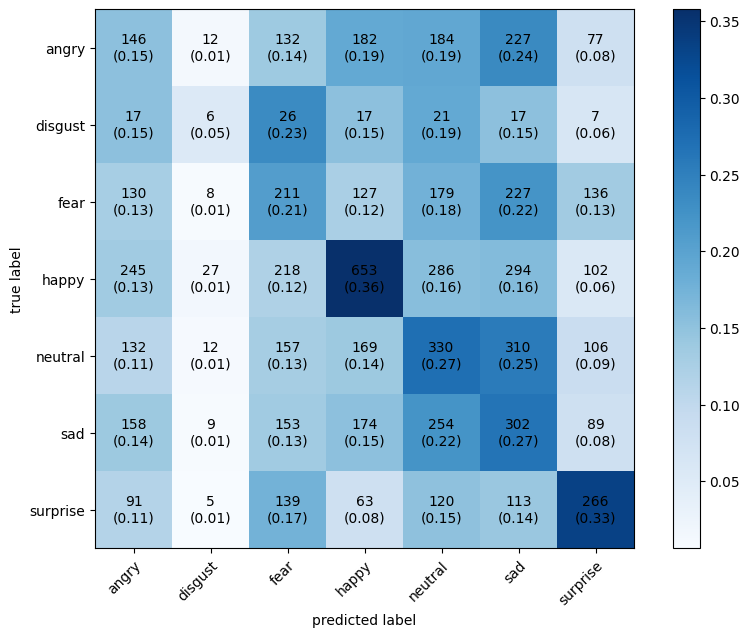

In [55]:
results_committee_sampling = active_learning(
    x_pool, y_pool, "query_by_committee", trained_model, 7, Face_class_names
)

# Plot All Metrics


## Accuracy


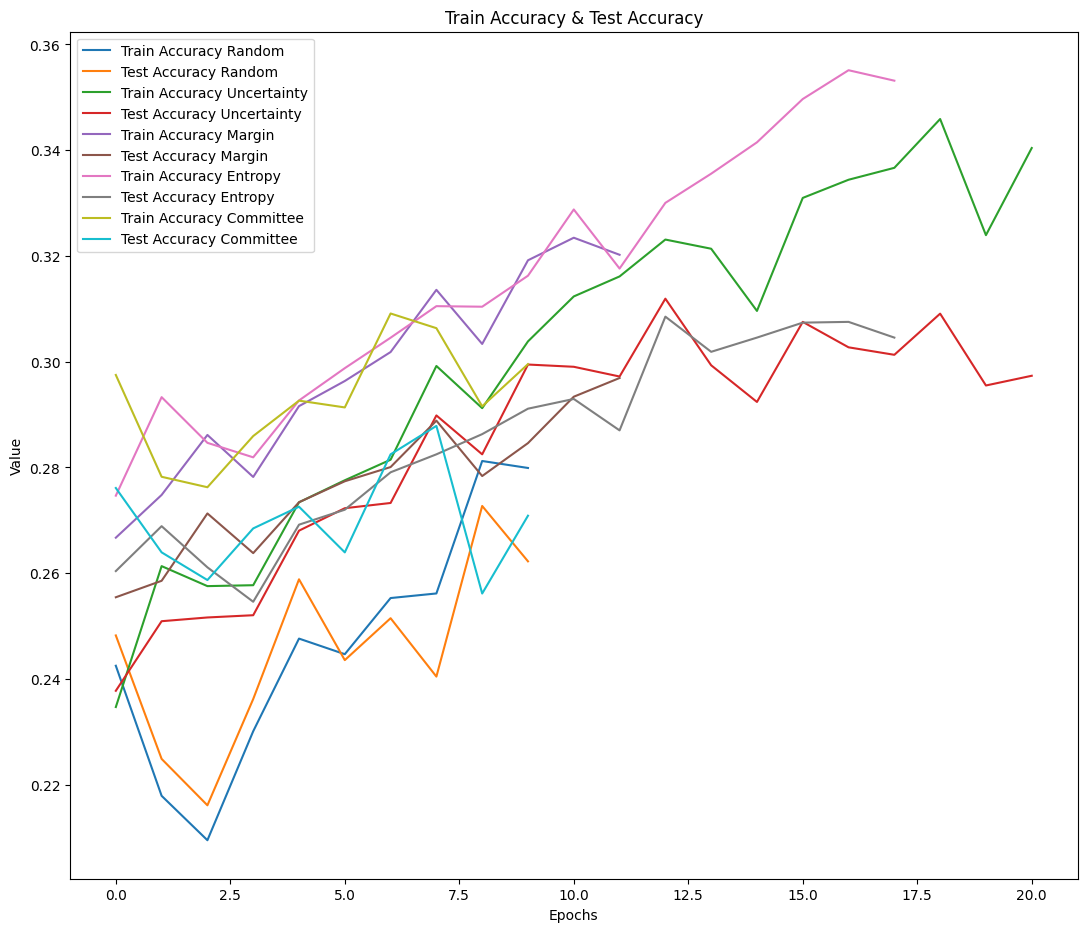

Train Accuracy Random: 0.279900072863537
Test Accuracy Random: 0.2622417211532593
Train Accuracy Uncertainty: 0.3404115054994622
Test Accuracy Uncertainty: 0.29733937978744507
Train Accuracy Margin: 0.3202178966725651
Test Accuracy Margin: 0.29691481590270996
Train Accuracy Entropy: 0.3531452760140176
Test Accuracy Entropy: 0.30455702543258667
Train Accuracy Committee: 0.2995385309323063
Test Accuracy Committee: 0.27087461948394775


In [56]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Train Accuracy"], label="Train Accuracy Random")
plt.plot(results_random_sampling["Test Accuracy"], label="Test Accuracy Random")
plt.plot(results_uncertainty_sampling["Train Accuracy"], label="Train Accuracy Uncertainty")
plt.plot(results_uncertainty_sampling["Test Accuracy"], label="Test Accuracy Uncertainty")
plt.plot(results_margin_sampling["Train Accuracy"], label="Train Accuracy Margin")
plt.plot(results_margin_sampling["Test Accuracy"], label="Test Accuracy Margin")
plt.plot(results_entropy_sampling["Train Accuracy"], label="Train Accuracy Entropy")
plt.plot(results_entropy_sampling["Test Accuracy"], label="Test Accuracy Entropy")
plt.plot(results_committee_sampling["Train Accuracy"], label="Train Accuracy Committee")
plt.plot(results_committee_sampling["Test Accuracy"], label="Test Accuracy Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Train Accuracy & Test Accuracy")
plt.legend()
plt.savefig("reports_Face/model_after_al_accuracy.png")
plt.show()

print(f"Train Accuracy Random: {results_random_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Random: {results_random_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Uncertainty: {results_uncertainty_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Uncertainty: {results_uncertainty_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Margin: {results_margin_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Margin: {results_margin_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Entropy: {results_entropy_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Entropy: {results_entropy_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Committee: {results_committee_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Committee: {results_committee_sampling['Test Accuracy'][-1]}")

## Loss

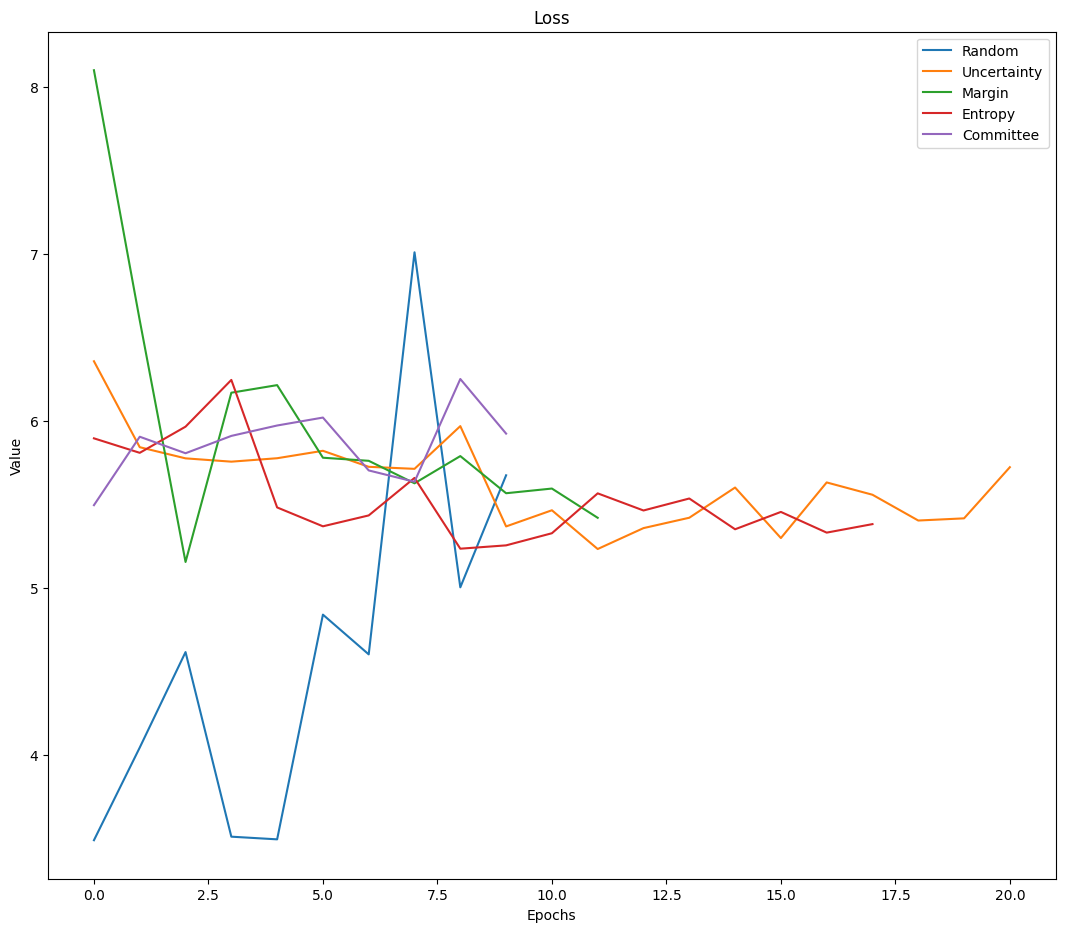

Random: 5.674921989440918
Uncertainty: 5.723464488983154
Margin: 5.420322895050049
Entropy: 5.382535934448242
Committee: 5.924568176269531


In [57]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Loss"], label="Random")
plt.plot(results_uncertainty_sampling["Loss"], label="Uncertainty")
plt.plot(results_margin_sampling["Loss"], label="Margin")
plt.plot(results_entropy_sampling["Loss"], label="Entropy")
plt.plot(results_committee_sampling["Loss"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")
plt.legend()
plt.savefig("reports_Face/model_after_al_loss.png")
plt.show()

print(f"Random: {results_random_sampling['Loss'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Loss'][-1]}")
print(f"Margin: {results_margin_sampling['Loss'][-1]}")
print(f"Entropy: {results_entropy_sampling['Loss'][-1]}")
print(f"Committee: {results_committee_sampling['Loss'][-1]}")

## Precision


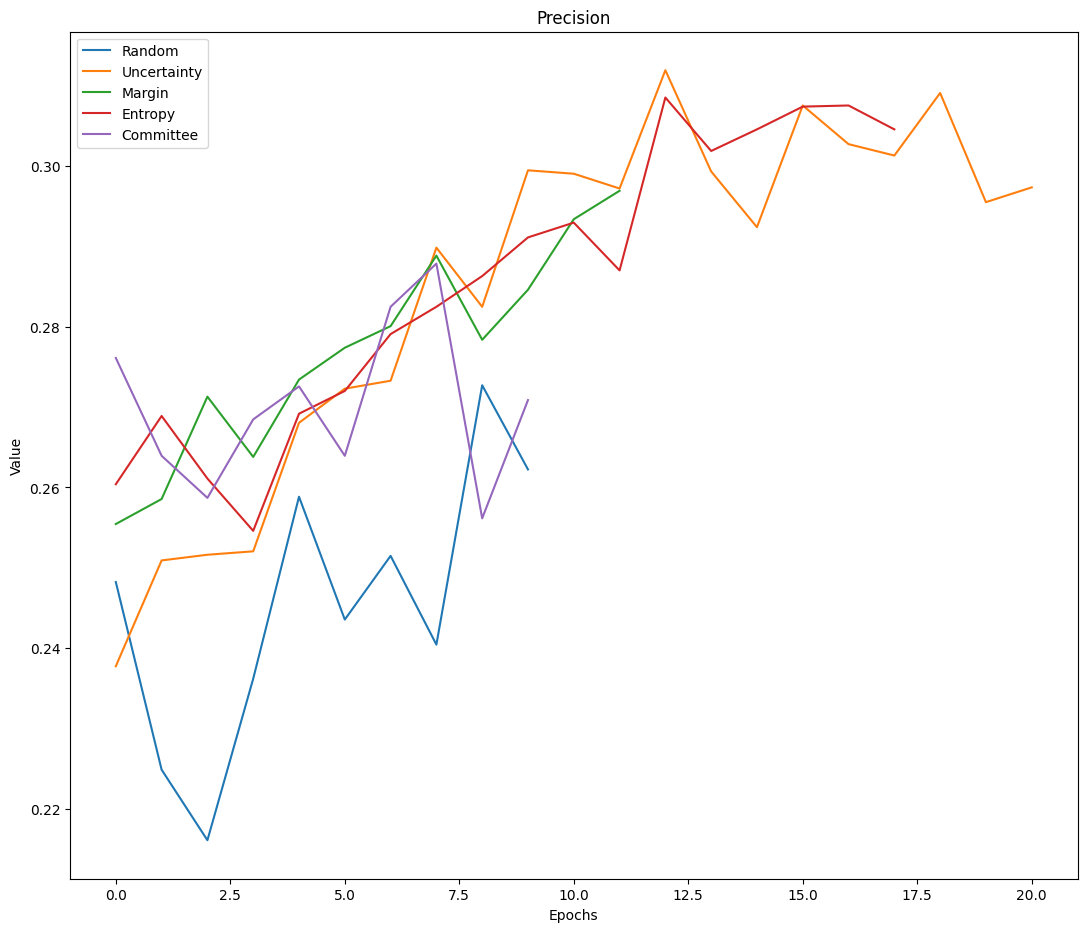

Random: 0.2622417211532593
Uncertainty: 0.29733937978744507
Margin: 0.29691481590270996
Entropy: 0.30455702543258667
Committee: 0.27087461948394775


In [58]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Precision"], label="Random")
plt.plot(results_uncertainty_sampling["Precision"], label="Uncertainty")
plt.plot(results_margin_sampling["Precision"], label="Margin")
plt.plot(results_entropy_sampling["Precision"], label="Entropy")
plt.plot(results_committee_sampling["Precision"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
plt.legend()
plt.savefig("reports_Face/model_after_al_precision.png")
plt.show()

print(f"Random: {results_random_sampling['Precision'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Precision'][-1]}")
print(f"Margin: {results_margin_sampling['Precision'][-1]}")
print(f"Entropy: {results_entropy_sampling['Precision'][-1]}")
print(f"Committee: {results_committee_sampling['Precision'][-1]}")

## Recall


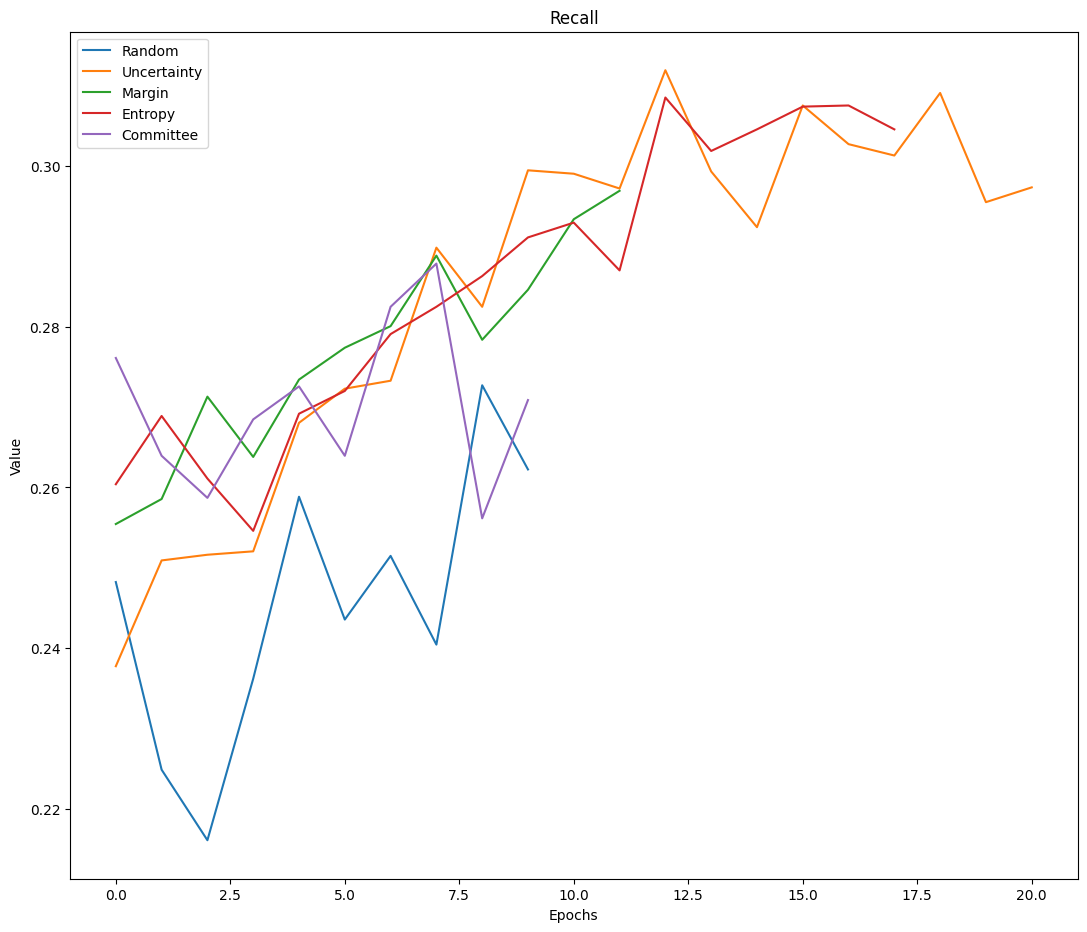

Random: 0.2622417211532593
Uncertainty: 0.29733937978744507
Margin: 0.29691481590270996
Entropy: 0.30455702543258667
Committee: 0.27087461948394775


In [59]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Recall"], label="Random")
plt.plot(results_uncertainty_sampling["Recall"], label="Uncertainty")
plt.plot(results_margin_sampling["Recall"], label="Margin")
plt.plot(results_entropy_sampling["Recall"], label="Entropy")
plt.plot(results_committee_sampling["Recall"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
plt.legend()
plt.savefig("reports_Face/model_after_al_recall.png")
plt.show()

print(f"Random: {results_random_sampling['Recall'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Recall'][-1]}")
print(f"Margin: {results_margin_sampling['Recall'][-1]}")
print(f"Entropy: {results_entropy_sampling['Recall'][-1]}")
print(f"Committee: {results_committee_sampling['Recall'][-1]}")

## F1 Score


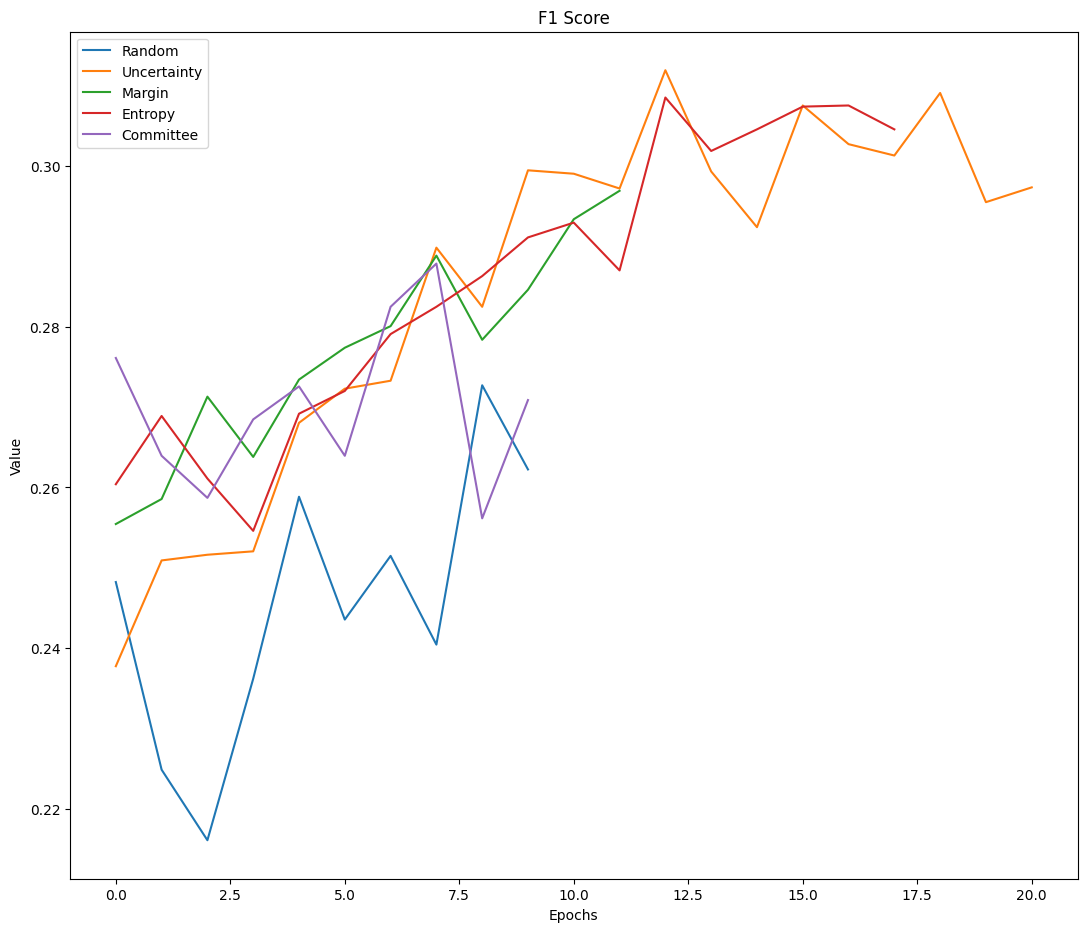

Random: 0.2622417211532593
Uncertainty: 0.29733937978744507
Margin: 0.29691481590270996
Entropy: 0.30455702543258667
Committee: 0.27087461948394775


In [60]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["F1 Score"], label="Random")
plt.plot(results_uncertainty_sampling["F1 Score"], label="Uncertainty")
plt.plot(results_margin_sampling["F1 Score"], label="Margin")
plt.plot(results_entropy_sampling["F1 Score"], label="Entropy")
plt.plot(results_committee_sampling["F1 Score"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
plt.legend()
plt.savefig("reports_Face/model_after_al_f1_score.png")
plt.show()

print(f"Random: {results_random_sampling['F1 Score'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['F1 Score'][-1]}")
print(f"Margin: {results_margin_sampling['F1 Score'][-1]}")
print(f"Entropy: {results_entropy_sampling['F1 Score'][-1]}")
print(f"Committee: {results_committee_sampling['F1 Score'][-1]}")

In [61]:
import shutil; shutil.rmtree('/kaggle/working/models')